In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

In [2]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [3]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))
directory

'/data/user/boiger_r/aerosol'

In [4]:
test_datafile = directory +'/aerosol_data/raw_data/pre_log_ts-0.2_wl-532_ta-5-85-96-176_13_09/test_dataset.hdf5'




In [5]:
#model_name = 'invertible_model'
#val_model_name = 'forward_model'

In [6]:
#model_dir = directory +'/aerosol_results/simulated_data/models_overview/models_asha16'

In [7]:
#plot_dir = directory +'/aerosol_results/simulated_data/invertible_model4/plots/model'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)

In [8]:
#test_datafile = directory +'/aerosol_data/raw_data/raw_data_preprocessed_wo_angles/test_dataset.hdf5'

In [9]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

In [10]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/'
directory1 = directory1 + 'paper_results_scan/version5'


In [11]:
plot_dir = directory1 + '/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
#
model_dir = directory1 +'/model'
#if not os.path.exists(model_dir):
#    os.makedirs(model_dir)

In [12]:
model_dir

'/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_scan/version5/model'

# Load the model and the data (dvar, qoi) for testing

In [13]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [14]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

In [15]:
dvar_test.describe()

k_532nm         V_tot      R_median           GSD             n
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.062797   2494.405197      1.325892      1.425071      1.465052
std        0.042165   1448.337398      0.679264      0.014348      0.077823
min        0.000050      1.034816      0.150249      1.400004      1.330004
25%        0.028657   1231.452686      0.740122      1.412740      1.398144
50%        0.057301   2487.279890      1.326080      1.425043      1.465069
75%        0.089141   3754.038491      1.914484      1.437421      1.532431
max        0.197673   4998.589326      2.499893      1.450000      1.599996

In [16]:
qoi_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       -15.346368   -15.647405   -15.970624   -16.311292   -16.653436   
1       -16.014276   -16.163742   -16.331920   -16.516203   -16.713155   
2       -15.012475   -15.523168   -16.036147   -16.531054   -16.993892   
3       -15.110576   -15.127886   -15.148264   -15.171547   -15.197773   
4       -15.174501   -15.305256   -15.452063   -15.612544   -15.783912   
...            ...          ...          ...          ...          ...   
19995   -14.684202   -15.030477   -15.398550   -15.783268   -16.160502   
19996   -15.173373   -15.617139   -16.067307   -16.508342   -16.909186   
19997   -15.379258   -15.411835   -15.449856   -15.493067   -15.541145   
19998   -14.784675   -15.078137   -15.392046   -15.719185   -16.045682   
19999   -15.515366   -16.027250   -16.539644   -17.031266   -17.492659   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -16.991183    -17.330672    -17.640897    -17.953306    -18.235696   
1        -16.921192    -17.137610    -17.357178    -17.592391    -17.812220   
2        -17.371364    -17.737432    -18.033515    -18.265816    -18.461357   
3        -15.226795    -15.258587    -15.293043    -15.331595    -15.369561   
4        -15.964517    -16.152045    -16.342427    -16.546712    -16.736172   
...             ...           ...           ...           ...           ...   
19995    -16.518349    -16.876763    -17.199644    -17.509242    -17.786276   
19996    -17.247239    -17.559565    -17.813364    -17.990783    -18.156242   
19997    -15.593900    -15.650971    -15.712164    -15.780053    -15.845553   
19998    -16.366749    -16.678024    -16.959743    -17.213962    -17.454191   
19999    -17.866221    -18.232874    -18.537709    -18.784121    -18.989895   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
0      ...      -0.008775      -0.020407      -0.026872      -0.026926   
1      ...      -0.006793       0.002603       0.010576       0.016693   
2      ...       0.018328       0.016053       0.013968       0.012053   
3      ...      -0.021345      -0.021064      -0.020148      -0.018704   
4      ...      -0.115990      -0.101880      -0.085679      -0.068257   
...    ...            ...            ...            ...            ...   
19995  ...      -0.006213      -0.026926      -0.041506      -0.048335   
19996  ...       0.249670       0.243160       0.227130       0.196210   
19997  ...      -0.227540      -0.216710      -0.202010      -0.183830   
19998  ...      -0.109080      -0.129340      -0.156470      -0.187180   
19999  ...      -0.004700      -0.008815      -0.010735      -0.009999   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
0          -0.019522      -0.004227       0.017765       0.042165   
1           0.020687       0.022496       0.022268       0.020334   
2           0.010285       0.008643       0.007115       0.005690   
3          -0.016848      -0.014699      -0.012379      -0.010006   
4          -0.050761      -0.034486      -0.020627      -0.010009   
...              ...            ...            ...            ...   
19995      -0.045739      -0.032134      -0.006891       0.027376   
19996       0.154640       0.109550       0.064009       0.022482   
19997      -0.162800      -0.139800      -0.115890      -0.092175   
19998      -0.218290      -0.245920      -0.264810      -0.268930   
19999      -0.006514      -0.000717       0.006341       0.013076   

       P12_0.532_174  P12_0.532_175  
0           0.061166       0.066825  
1           0.017159       0.013279  
2           0.004370       0.003168  
3          -0.007694      -0.005548  
4          -0.002906       0.000969  
...              ...            ...  
19995       0.061539       0.080851  
19996      -0.011816      -0.034087  
19997      -0.069719      -0.049461  
19998      -0.252300      -0.212900  
19999       0.017739       0.0190

In [17]:
qoi_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       -15.346368   -15.647405   -15.970624   -16.311292   -16.653436   
1       -16.014276   -16.163742   -16.331920   -16.516203   -16.713155   
2       -15.012475   -15.523168   -16.036147   -16.531054   -16.993892   
3       -15.110576   -15.127886   -15.148264   -15.171547   -15.197773   
4       -15.174501   -15.305256   -15.452063   -15.612544   -15.783912   
...            ...          ...          ...          ...          ...   
19995   -14.684202   -15.030477   -15.398550   -15.783268   -16.160502   
19996   -15.173373   -15.617139   -16.067307   -16.508342   -16.909186   
19997   -15.379258   -15.411835   -15.449856   -15.493067   -15.541145   
19998   -14.784675   -15.078137   -15.392046   -15.719185   -16.045682   
19999   -15.515366   -16.027250   -16.539644   -17.031266   -17.492659   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -16.991183    -17.330672    -17.640897    -17.953306    -18.235696   
1        -16.921192    -17.137610    -17.357178    -17.592391    -17.812220   
2        -17.371364    -17.737432    -18.033515    -18.265816    -18.461357   
3        -15.226795    -15.258587    -15.293043    -15.331595    -15.369561   
4        -15.964517    -16.152045    -16.342427    -16.546712    -16.736172   
...             ...           ...           ...           ...           ...   
19995    -16.518349    -16.876763    -17.199644    -17.509242    -17.786276   
19996    -17.247239    -17.559565    -17.813364    -17.990783    -18.156242   
19997    -15.593900    -15.650971    -15.712164    -15.780053    -15.845553   
19998    -16.366749    -16.678024    -16.959743    -17.213962    -17.454191   
19999    -17.866221    -18.232874    -18.537709    -18.784121    -18.989895   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
0      ...      -0.008775      -0.020407      -0.026872      -0.026926   
1      ...      -0.006793       0.002603       0.010576       0.016693   
2      ...       0.018328       0.016053       0.013968       0.012053   
3      ...      -0.021345      -0.021064      -0.020148      -0.018704   
4      ...      -0.115990      -0.101880      -0.085679      -0.068257   
...    ...            ...            ...            ...            ...   
19995  ...      -0.006213      -0.026926      -0.041506      -0.048335   
19996  ...       0.249670       0.243160       0.227130       0.196210   
19997  ...      -0.227540      -0.216710      -0.202010      -0.183830   
19998  ...      -0.109080      -0.129340      -0.156470      -0.187180   
19999  ...      -0.004700      -0.008815      -0.010735      -0.009999   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
0          -0.019522      -0.004227       0.017765       0.042165   
1           0.020687       0.022496       0.022268       0.020334   
2           0.010285       0.008643       0.007115       0.005690   
3          -0.016848      -0.014699      -0.012379      -0.010006   
4          -0.050761      -0.034486      -0.020627      -0.010009   
...              ...            ...            ...            ...   
19995      -0.045739      -0.032134      -0.006891       0.027376   
19996       0.154640       0.109550       0.064009       0.022482   
19997      -0.162800      -0.139800      -0.115890      -0.092175   
19998      -0.218290      -0.245920      -0.264810      -0.268930   
19999      -0.006514      -0.000717       0.006341       0.013076   

       P12_0.532_174  P12_0.532_175  
0           0.061166       0.066825  
1           0.017159       0.013279  
2           0.004370       0.003168  
3          -0.007694      -0.005548  
4          -0.002906       0.000969  
...              ...            ...  
19995       0.061539       0.080851  
19996      -0.011816      -0.034087  
19997      -0.069719      -0.049461  
19998      -0.252300      -0.212900  
19999       0.017739       0.0190

In [18]:
qoi_test.describe()

P11_0.532_5   P11_0.532_6   P11_0.532_7   P11_0.532_8   P11_0.532_9  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -15.752014    -16.042350    -16.339971    -16.634126    -16.919093   
std        1.044242      1.096547      1.172695      1.258449      1.346876   
min      -23.400995    -23.934223    -24.459866    -24.952125    -25.406462   
25%      -16.194000    -16.538068    -16.916248    -17.314241    -17.699712   
50%      -15.492024    -15.836117    -16.175804    -16.502399    -16.821576   
75%      -15.013858    -15.256525    -15.484261    -15.689728    -15.884467   
max      -14.152411    -14.202925    -14.261282    -14.326936    -14.399230   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean     -17.175763    -17.427254    -17.649306    -17.851162    -18.033961   
std        1.417177      1.487137      1.541801      1.579622      1.612336   
min      -25.769098    -26.119946    -26.398432    -26.601687    -26.776308   
25%      -18.030076    -18.349943    -18.619427    -18.847135    -19.045931   
50%      -17.125872    -17.426985    -17.692070    -17.933052    -18.151990   
75%      -16.076066    -16.270717    -16.453656    -16.634277    -16.801050   
max      -14.477508    -14.561067    -14.637742    -14.679660    -14.720787   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
count  ...   20000.000000   20000.000000   20000.000000   20000.000000   
mean   ...      -0.105301      -0.103885      -0.100766      -0.096017   
std    ...       0.185790       0.176725       0.166040       0.152955   
min    ...      -0.639540      -0.621930      -0.595210      -0.570720   
25%    ...      -0.207660      -0.201153      -0.191600      -0.179792   
50%    ...      -0.051160      -0.052344      -0.052525      -0.051206   
75%    ...       0.003927       0.000400      -0.001498      -0.002567   
max    ...       0.568690       0.581320       0.584930       0.561040   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
count   20000.000000   20000.000000   20000.000000   20000.000000   
mean       -0.089323      -0.080539      -0.069704      -0.057010   
std         0.138148       0.122390       0.105933       0.090044   
min        -0.531340      -0.475830      -0.415630      -0.351730   
25%        -0.164925      -0.147623      -0.128103      -0.106703   
50%        -0.047327      -0.042125      -0.035580      -0.029487   
75%        -0.001958       0.000586       0.005309       0.007007   
max         0.522760       0.484560       0.410460       0.360220   

       P12_0.532_174  P12_0.532_175  
count   20000.000000   20000.000000  
mean       -0.043299      -0.029895  
std         0.075687       0.063720  
min        -0.339120      -0.315290  
25%        -0.083535      -0.061469  
50%        -0.021829      -0.014176  
75%         0.007546       0.007559  
max         0.273460       0.148490  

[8 rows x 320 columns]

In [19]:
qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [20]:
qoi_test_plot = qoi_test.copy()

# Prediction

## Forward Prediction

In [21]:
import time
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
time = (end-start)/len(dvar_test)
time

0.00029427765607833864

In [22]:
qoi_columns

Index(['P11_0.532_5', 'P11_0.532_6', 'P11_0.532_7', 'P11_0.532_8',
       'P11_0.532_9', 'P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12',
       'P11_0.532_13', 'P11_0.532_14',
       ...
       'P12_0.532_166', 'P12_0.532_167', 'P12_0.532_168', 'P12_0.532_169',
       'P12_0.532_170', 'P12_0.532_171', 'P12_0.532_172', 'P12_0.532_173',
       'P12_0.532_174', 'P12_0.532_175'],
      dtype='object', length=320)

In [23]:
qoi_pred_fw.shape

(20000, 320)

In [24]:
qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)
qoi_pred_fw

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       -15.349398   -15.701470   -15.980143   -16.314902   -16.692589   
1       -16.028138   -16.149517   -16.346745   -16.489373   -16.695785   
2       -15.068135   -15.588908   -16.081791   -16.546951   -17.023711   
3       -15.109731   -15.112435   -15.125669   -15.184051   -15.189707   
4       -15.195180   -15.362180   -15.466927   -15.641788   -15.806892   
...            ...          ...          ...          ...          ...   
19995   -14.723919   -15.046925   -15.440750   -15.828029   -16.147632   
19996   -15.186470   -15.626264   -16.164677   -16.565165   -16.972512   
19997   -15.425785   -15.445987   -15.493863   -15.480332   -15.551781   
19998   -14.815969   -15.091399   -15.463911   -15.734399   -16.049871   
19999   -15.500697   -16.023471   -16.524006   -17.028086   -17.478645   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -17.022586    -17.305286    -17.663572    -17.890351    -18.226322   
1        -16.924930    -17.180163    -17.460278    -17.639528    -17.861769   
2        -17.431080    -17.761676    -18.003456    -18.257954    -18.517151   
3        -15.289217    -15.271535    -15.269070    -15.301393    -15.453560   
4        -15.981888    -16.159415    -16.353204    -16.489208    -16.720694   
...             ...           ...           ...           ...           ...   
19995    -16.523199    -16.863770    -17.204354    -17.476195    -17.744674   
19996    -17.350314    -17.599315    -17.826582    -18.047920    -18.189914   
19997    -15.589927    -15.659679    -15.677882    -15.774017    -15.872167   
19998    -16.384549    -16.707242    -16.937830    -17.189845    -17.437955   
19999    -17.844857    -18.214928    -18.514696    -18.753648    -18.988882   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
0      ...      -0.011281      -0.027260      -0.024697      -0.022120   
1      ...      -0.003568       0.006580       0.013896       0.011120   
2      ...       0.021036       0.015590       0.013022       0.013131   
3      ...      -0.017009      -0.020432      -0.019200      -0.018880   
4      ...      -0.114107      -0.105495      -0.087396      -0.071971   
...    ...            ...            ...            ...            ...   
19995  ...      -0.002756      -0.026271      -0.041569      -0.050929   
19996  ...       0.243474       0.235474       0.219163       0.197145   
19997  ...      -0.210867      -0.196391      -0.184854      -0.171326   
19998  ...      -0.112682      -0.138081      -0.153010      -0.186883   
19999  ...      -0.000547      -0.006710      -0.008181      -0.005491   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
0          -0.017949       0.000999       0.026267       0.051362   
1           0.013250       0.023863       0.018029       0.019411   
2           0.009026       0.011153       0.009285       0.001029   
3          -0.022307      -0.014919      -0.017707      -0.018343   
4          -0.054800      -0.037913      -0.026091      -0.016505   
...              ...            ...            ...            ...   
19995      -0.047635      -0.038527      -0.009971       0.023939   
19996       0.155941       0.105621       0.067494       0.020807   
19997      -0.144253      -0.128852      -0.103334      -0.086249   
19998      -0.221936      -0.250032      -0.270248      -0.278533   
19999      -0.003866       0.000382       0.009730       0.016068   

       P12_0.532_174  P12_0.532_175  
0           0.065637       0.070570  
1           0.016693       0.016245  
2           0.006364       0.003291  
3          -0.012201      -0.008194  
4          -0.008261      -0.002804  
...              ...            ...  
19995       0.060384       0.080716  
19996      -0.014367      -0.037101  
19997      -0.067857      -0.047464  
19998      -0.262679      -0.220428  
19999       0.018977       0.0211

In [25]:
np.min(np.abs(qoi_pred_fw.mean()))

0.0002591125278798156

In [26]:
qoi_pred_plot_fw = qoi_pred_fw.copy()
#qoi_pred_plot_fw

## Inverse prediction

In [27]:
import time
n_tries = 32
start = time.time()
dvar_pred_iv = surr.sample_n_tries(qoi_test.values, batch_size=128, n_tries=n_tries)
end = time.time()
iv_time = (end-start)/len(qoi_test)
iv_time

0.018567616605758668

In [28]:
dvar_columns

Index(['k_532nm', 'V_tot', 'R_median', 'GSD', 'n'], dtype='object')

In [29]:
dvar_pred_iv = pd.DataFrame(data=dvar_pred_iv, columns=dvar_columns)
dvar_pred_iv

k_532nm        V_tot  R_median       GSD         n
0      0.058627  2350.759407  1.368747  1.418145  1.345998
1      0.178161  1158.824768  0.880789  1.416214  1.564733
2      0.176553  4827.262229  2.012788  1.405125  1.558725
3      0.047253  4845.707938  0.278091  1.414017  1.338379
4      0.118126  2578.406801  0.823293  1.442656  1.435434
...         ...          ...       ...       ...       ...
19995  0.047633  4721.503087  1.494790  1.413854  1.334781
19996  0.012944  3579.685965  1.837128  1.404033  1.468694
19997  0.042321  2045.106134  0.389157  1.431155  1.392691
19998  0.013185  4033.882576  1.355816  1.408138  1.567527
19999  0.097286  3070.392613  2.047103  1.421171  1.340471

[20000 rows x 5 columns]

In [30]:
dvar_pred_iv.describe()

k_532nm         V_tot      R_median           GSD             n
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.062379   2515.010296      1.327884      1.424168      1.465326
std        0.042145   1455.341857      0.675997      0.013390      0.077627
min       -0.003700    -79.488064      0.102050      1.399984      1.324549
25%        0.028289   1246.768944      0.749421      1.412395      1.398529
50%        0.056655   2504.874657      1.326676      1.424174      1.465070
75%        0.088613   3781.836411      1.915310      1.435936      1.532591
max        0.199942   5183.070080      2.517501      1.449274      1.609636

# Calculate metrics

## R2

Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$


In [31]:
#metric_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])
metric_fw = RSquaredSeparated()

r2_adj_fw = metric_fw.call(qoi_test.values, qoi_pred_fw.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=4)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
print('Forward model: ','R2_min = ', min(r2_adj_fw.min()),';  R2_max = ', max(r2_adj_fw.max()))

r2_adj_fw

Forward model:  R2_min =  0.993 ;  R2_max =  0.9994


P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       0.9969       0.9978        0.998       0.9984       0.9984   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0        0.9984        0.9985        0.9986        0.9986        0.9986  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0         0.9962         0.9962          0.996         0.9962         0.9963   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0         0.9952         0.9955         0.9953          0.993         0.9945  

[1 rows x 320 columns]

In [32]:
r2_adj_fw.mean(axis = 1)

0    0.998708
dtype: float64

In [33]:
r2_fw_sorted = r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis = 1,ascending=True)

In [34]:
r2_fw_sorted

P12_0.532_174  P11_0.532_68  P12_0.532_175  P12_0.532_171  P12_0.532_173  \
0          0.993        0.9941         0.9945         0.9952         0.9953   

   P12_0.532_172  P12_0.532_168  P12_0.532_165  P12_0.532_169  P12_0.532_167  \
0         0.9955          0.996          0.996         0.9962         0.9962   

   ...  P12_0.532_47  P12_0.532_41  P12_0.532_39  P12_0.532_29  P12_0.532_30  \
0  ...        0.9993        0.9994        0.9994        0.9994        0.9994   

   P12_0.532_31  P12_0.532_51  P12_0.532_36  P12_0.532_44  P12_0.532_48  
0        0.9994        0.9994        0.9994        0.9994        0.9994  

[1 rows x 320 columns]

In [35]:
#np.mean(r2_fw_sorted.drop(['P12_0.450_0','P12_0.532_0','P12_0.630_0'],axis =1).mean())

In [36]:
#metric_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric_iv = RSquaredSeparated()

r2_adj_iv = metric_iv.call(dvar_test.values, dvar_pred_iv.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Inverse model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))

r2_adj_iv

Inverse model:  R2_min =  0.91 ;  R2_max =  1.0


k_532nm  V_tot  R_median   GSD    n
0      1.0    1.0       1.0  0.91  1.0

In [37]:
np.mean(r2_adj_iv, axis = 1)

0    0.982
dtype: float64

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small


In [38]:
abs_error_fw = np.abs( qoi_test - qoi_pred_fw)
abs_error_fw

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0         0.003030     0.054066     0.009519     0.003610     0.039153   
1         0.013862     0.014225     0.014825     0.026830     0.017369   
2         0.055661     0.065740     0.045644     0.015897     0.029818   
3         0.000845     0.015451     0.022595     0.012504     0.008066   
4         0.020679     0.056924     0.014864     0.029244     0.022980   
...            ...          ...          ...          ...          ...   
19995     0.039716     0.016448     0.042200     0.044762     0.012871   
19996     0.013098     0.009125     0.097369     0.056823     0.063325   
19997     0.046526     0.034152     0.044007     0.012734     0.010636   
19998     0.031294     0.013262     0.071866     0.015213     0.004189   
19999     0.014668     0.003779     0.015638     0.003180     0.014014   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0          0.031403      0.025386      0.022675      0.062954      0.009374   
1          0.003738      0.042552      0.103100      0.047137      0.049549   
2          0.059717      0.024243      0.030059      0.007862      0.055794   
3          0.062423      0.012948      0.023973      0.030202      0.083999   
4          0.017371      0.007370      0.010776      0.057503      0.015478   
...             ...           ...           ...           ...           ...   
19995      0.004850      0.012993      0.004709      0.033047      0.041602   
19996      0.103075      0.039750      0.013218      0.057137      0.033672   
19997      0.003973      0.008708      0.034282      0.006036      0.026615   
19998      0.017800      0.029218      0.021913      0.024116      0.016236   
19999      0.021364      0.017947      0.023013      0.030474      0.001013   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
0      ...       0.002505       0.006853       0.002175       0.004806   
1      ...       0.003224       0.003978       0.003320       0.005573   
2      ...       0.002708       0.000463       0.000946       0.001078   
3      ...       0.004336       0.000632       0.000948       0.000176   
4      ...       0.001883       0.003615       0.001717       0.003714   
...    ...            ...            ...            ...            ...   
19995  ...       0.003457       0.000655       0.000063       0.002594   
19996  ...       0.006196       0.007686       0.007967       0.000935   
19997  ...       0.016673       0.020319       0.017156       0.012504   
19998  ...       0.003602       0.008741       0.003460       0.000297   
19999  ...       0.004152       0.002105       0.002554       0.004508   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
0           0.001573       0.005226       0.008502       0.009197   
1           0.007437       0.001367       0.004239       0.000923   
2           0.001259       0.002509       0.002171       0.004661   
3           0.005459       0.000220       0.005328       0.008337   
4           0.004039       0.003427       0.005464       0.006496   
...              ...            ...            ...            ...   
19995       0.001896       0.006393       0.003079       0.003437   
19996       0.001301       0.003929       0.003485       0.001675   
19997       0.018547       0.010948       0.012556       0.005926   
19998       0.003646       0.004112       0.005438       0.009603   
19999       0.002649       0.001099       0.003389       0.002992   

       P12_0.532_174  P12_0.532_175  
0           0.004471       0.003745  
1           0.000466       0.002966  
2           0.001995       0.000123  
3           0.004507       0.002646  
4           0.005354       0.003774  
...              ...            ...  
19995       0.001155       0.000135  
19996       0.002551       0.003014  
19997       0.001862       0.001997  
19998       0.010379       0.007528  
19999       0.001238       0.0020

In [39]:
#rel_error_fw.iloc[6401]['P12_0.532_156'] = 9789120.031523209
# diff_fw.iloc[6401]['P12_0.532_156'] = -0.017945414841788347
# qoi_test.iloc[6401]['P12_0.532_156'] = -1.9332e-07
# qoi_pred_fw.iloc[6401]['P12_0.532_156'] = 0.017945221521788346

In [40]:
rel_error_fw = abs_error_fw / (qoi_test) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [41]:
#qoi_test.to_csv(f'{plot_dir}/qoi_test.csv')

In [42]:
#qoi_pred_fw.to_csv(f'{plot_dir}/qoi_pred_fw.csv')

In [43]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
50%         0.02         0.02         0.02         0.02         0.02   
75%         0.04         0.04         0.04         0.03         0.04   
90%         0.07         0.06         0.06         0.05         0.06   
95%         0.10         0.07         0.08         0.07         0.08   
99%         0.17         0.12         0.13         0.12         0.15   

     P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
50%          0.03          0.02          0.02          0.03          0.03   
75%          0.05          0.04          0.04          0.05          0.05   
90%          0.07          0.07          0.07          0.08          0.08   
95%          0.09          0.10          0.09          0.10          0.10   
99%          0.15          0.17          0.16          0.16          0.16   

     ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
50%  ...           0.01           0.01           0.01           0.00   
75%  ...           0.01           0.01           0.01           0.01   
90%  ...           0.02           0.02           0.02           0.02   
95%  ...           0.02           0.02           0.02           0.02   
99%  ...           0.04           0.03           0.03           0.03   

     P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
50%           0.00           0.00           0.00           0.00   
75%           0.01           0.01           0.01           0.01   
90%           0.01           0.01           0.01           0.01   
95%           0.02           0.02           0.01           0.01   
99%           0.03           0.03           0.02           0.02   

     P12_0.532_174  P12_0.532_175  
50%           0.00           0.00  
75%           0.01           0.00  
90%           0.01           0.01  
95%           0.01           0.01  
99%           0.02           0.02  

[5 rows x 320 columns]

In [44]:
abs_error_table_fw.sort_values(by=abs_error_table_fw.index[3], axis = 1,ascending=False)

P11_0.532_68  P11_0.532_17  P11_0.532_24  P11_0.532_60  P11_0.532_33  \
50%          0.05          0.03          0.03          0.02          0.04   
75%          0.11          0.06          0.05          0.05          0.06   
90%          0.19          0.10          0.09          0.08          0.09   
95%          0.26          0.14          0.12          0.12          0.12   
99%          0.53          0.27          0.20          0.20          0.22   

     P11_0.532_169  P11_0.532_167  P11_0.532_174  P11_0.532_16  P11_0.532_164  \
50%           0.03           0.02           0.03          0.03           0.03   
75%           0.05           0.05           0.06          0.05           0.05   
90%           0.08           0.08           0.09          0.08           0.08   
95%           0.11           0.11           0.11          0.11           0.11   
99%           0.18           0.20           0.17          0.19           0.18   

     ...  P12_0.532_11  P12_0.532_20  P12_0.532_13  P12_0.532_14  \
50%  ...           0.0          0.00           0.0           0.0   
75%  ...           0.0          0.00           0.0           0.0   
90%  ...           0.0          0.00           0.0           0.0   
95%  ...           0.0          0.00           0.0           0.0   
99%  ...           0.0          0.01           0.0           0.0   

     P12_0.532_15  P12_0.532_16  P12_0.532_17  P12_0.532_18  P12_0.532_19  \
50%           0.0          0.00          0.00          0.00          0.00   
75%           0.0          0.00          0.00          0.00          0.00   
90%           0.0          0.00          0.00          0.00          0.00   
95%           0.0          0.00          0.00          0.00          0.00   
99%           0.0          0.01          0.01          0.01          0.01   

     P12_0.532_5  
50%          0.0  
75%          0.0  
90%          0.0  
95%          0.0  
99%          0.0  

[5 rows x 320 columns]

In [45]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
50%         0.15         0.13         0.12         0.11         0.14   
75%         0.28         0.23         0.22         0.21         0.23   
90%         0.45         0.35         0.36         0.32         0.36   
95%         0.61         0.44         0.47         0.41         0.46   
99%         1.00         0.69         0.73         0.69         0.86   

     P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
50%          0.16          0.14          0.13          0.16          0.15   
75%          0.27          0.25          0.24          0.28          0.28   
90%          0.40          0.41          0.40          0.43          0.44   
95%          0.50          0.57          0.52          0.55          0.56   
99%          0.88          0.98          0.91          0.86          0.87   

     ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
50%  ...           6.66           7.14           6.89           7.14   
75%  ...          19.10          19.66          19.38          18.63   
90%  ...          52.00          50.99          54.61          48.80   
95%  ...         104.82         100.90         112.04          96.55   
99%  ...         532.81         518.36         577.75         477.30   

     P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
50%           7.23           8.66           7.87           7.35   
75%          20.81          25.16          21.92          19.24   
90%          54.25          70.09          58.50          50.93   
95%         102.94         142.68         116.03         105.44   
99%         514.07         702.58         548.48         495.86   

     P12_0.532_174  P12_0.532_175  
50%           8.28           7.45  
75%          22.28          19.34  
90%          62.06          53.57  
95%         129.21         120.39  
99%         557.40         554.28  

[5 rows x 320 columns]

In [46]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis = 1,ascending=False)

P12_0.532_171  P12_0.532_174  P12_0.532_175  P12_0.532_172  \
50%           8.66           8.28           7.45           7.87   
75%          25.16          22.28          19.34          21.92   
90%          70.09          62.06          53.57          58.50   
95%         142.68         129.21         120.39         116.03   
99%         702.58         557.40         554.28         548.48   

     P12_0.532_168  P12_0.532_165  P12_0.532_161  P12_0.532_164  \
50%           6.89           6.77           5.71           6.47   
75%          19.38          20.59          16.79          18.76   
90%          54.61          56.19          51.25          52.31   
95%         112.04         109.42         108.84         106.22   
99%         577.75         562.60         556.25         615.79   

     P12_0.532_173  P12_0.532_166  ...  P11_0.532_133  P11_0.532_121  \
50%           7.35           6.66  ...           0.07           0.07   
75%          19.24          19.10  ...           0.13           0.12   
90%          50.93          52.00  ...           0.22           0.21   
95%         105.44         104.82  ...           0.29           0.28   
99%         495.86         532.81  ...           0.52           0.57   

     P11_0.532_128  P11_0.532_79  P11_0.532_97  P11_0.532_114  P11_0.532_109  \
50%           0.07          0.08          0.07           0.07           0.07   
75%           0.13          0.14          0.13           0.12           0.13   
90%           0.21          0.22          0.21           0.21           0.21   
95%           0.28          0.28          0.28           0.28           0.28   
99%           0.53          0.56          0.49           0.53           0.51   

     P11_0.532_130  P11_0.532_129  P11_0.532_113  
50%           0.07           0.07           0.07  
75%           0.13           0.12           0.12  
90%           0.22           0.20           0.20  
95%           0.28           0.28           0.26  
99%           0.52           0.50           0.49  

[5 rows x 320 columns]

In [47]:
P11_532_columns = []
P12_532_columns = []
for name in qoi_columns:
    if 'P11' in name:
        P11_532_columns.append(name)
    if 'P12' in name:
        P12_532_columns.append(name)

In [48]:
abs_error_table_fw_P11 = abs_error_table_fw[P11_532_columns]
print('Absolute error P11')
print(abs_error_table_fw_P11.max(axis = 1))
abs_error_table_fw_P12 = abs_error_table_fw[P12_532_columns]
print('Absolute error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))


Absolute error P11
50%    0.05
75%    0.11
90%    0.19
95%    0.26
99%    0.53
dtype: float64
Absolute error P11/P12
50%    0.01
75%    0.01
90%    0.02
95%    0.03
99%    0.04
dtype: float64


In [49]:
#abs_error_table_fw_P12.drop(['P12_0.450_0'],axis = 1).max(axis =1)

In [50]:
#abs_error_table_fw_P12.sort_values(by=abs_error_table_fw_P12.index[3], axis = 1,ascending=False)

In [51]:
rel_error_table_fw_P11 = rel_error_table_fw[P11_532_columns]
print('Relative error P11')
print(rel_error_table_fw_P11.max(axis = 1))
rel_error_table_fw_P12 = rel_error_table_fw[P12_532_columns]
print('Relative error P11/P12')
print(rel_error_table_fw_P12.max(axis = 1))


Relative error P11
50%    0.24
75%    0.51
90%    0.90
95%    1.24
99%    2.72
dtype: float64
Relative error P11/P12
50%      8.66
75%     25.16
90%     70.09
95%    142.68
99%    702.58
dtype: float64


In [52]:
rel_error_table_fw_P11.sort_values(by=rel_error_table_fw_P11.index[3], axis = 1,ascending=False)

P11_0.532_68  P11_0.532_17  P11_0.532_33  P11_0.532_24  P11_0.532_16  \
50%          0.24          0.19          0.18          0.15          0.14   
75%          0.51          0.34          0.32          0.28          0.27   
90%          0.90          0.56          0.49          0.47          0.46   
95%          1.24          0.77          0.64          0.63          0.63   
99%          2.72          1.50          1.19          1.03          1.04   

     P11_0.532_5  P11_0.532_11  P11_0.532_14  P11_0.532_60  P11_0.532_13  ...  \
50%         0.15          0.14          0.15          0.11          0.16  ...   
75%         0.28          0.25          0.28          0.22          0.28  ...   
90%         0.45          0.41          0.44          0.38          0.43  ...   
95%         0.61          0.57          0.56          0.55          0.55  ...   
99%         1.00          0.98          0.87          0.92          0.86  ...   

     P11_0.532_126  P11_0.532_114  P11_0.532_121  P11_0.532_109  \
50%           0.08           0.07           0.07           0.07   
75%           0.14           0.12           0.12           0.13   
90%           0.22           0.21           0.21           0.21   
95%           0.29           0.28           0.28           0.28   
99%           0.54           0.53           0.57           0.51   

     P11_0.532_128  P11_0.532_129  P11_0.532_130  P11_0.532_97  P11_0.532_79  \
50%           0.07           0.07           0.07          0.07          0.08   
75%           0.13           0.12           0.13          0.13          0.14   
90%           0.21           0.20           0.22          0.21          0.22   
95%           0.28           0.28           0.28          0.28          0.28   
99%           0.53           0.50           0.52          0.49          0.56   

     P11_0.532_113  
50%           0.07  
75%           0.12  
90%           0.20  
95%           0.26  
99%           0.49  

[5 rows x 160 columns]

In [53]:
print('Forward model: max. abs. error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))

Forward model: max. abs. error P11/P12
50%    0.01
75%    0.01
90%    0.02
95%    0.03
99%    0.04
dtype: float64


In [54]:
print('Forward model: max. rel. error in % P11')
print(rel_error_table_fw_P11.max(axis = 1))

Forward model: max. rel. error in % P11
50%    0.24
75%    0.51
90%    0.90
95%    1.24
99%    2.72
dtype: float64


In [55]:
abs_error_iv = np.abs(dvar_test-dvar_pred_iv)
abs_error_iv

k_532nm       V_tot  R_median       GSD         n
0      0.001515   35.080496  0.008604  0.003882  0.000838
1      0.005945   37.374313  0.009337  0.005942  0.003815
2      0.003090  135.290921  0.020686  0.000364  0.001974
3      0.007739   28.583717  0.019943  0.009092  0.006674
4      0.000060   41.434499  0.016793  0.002215  0.001008
...         ...         ...       ...       ...       ...
19995  0.000205   43.026440  0.000082  0.000404  0.001304
19996  0.000016   45.493435  0.001613  0.001178  0.000357
19997  0.000127   29.408737  0.004128  0.000245  0.002434
19998  0.000316   44.406674  0.000334  0.001481  0.003917
19999  0.000775   32.207761  0.026252  0.005385  0.002086

[20000 rows x 5 columns]

In [56]:
rel_error_iv = abs_error_iv / (dvar_test) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [57]:
abs_error_table_iv = np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
abs_error_table_iv

k_532nm     V_tot  R_median     GSD       n
50%   0.0007   28.6159    0.0080  0.0021  0.0012
75%   0.0013   51.1297    0.0138  0.0039  0.0022
90%   0.0022   80.0578    0.0207  0.0068  0.0034
95%   0.0031  104.0176    0.0260  0.0092  0.0043
99%   0.0055  159.6749    0.0399  0.0154  0.0074

In [58]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
rel_error_table_iv

k_532nm    V_tot  R_median     GSD       n
50%   1.2592   1.4112    0.6862  0.1477  0.0835
75%   3.0318   2.5960    1.3195  0.2733  0.1475
90%   8.3704   4.8992    2.3172  0.4734  0.2295
95%  16.6004   8.7935    3.2063  0.6452  0.2936
99%  81.7635  50.4237    6.0125  1.0836  0.4964

In [59]:
print('Inverse model: max. rel. error in %')
print(rel_error_table_iv.max(axis = 1))

Inverse model: max. rel. error in %
50%     1.4112
75%     3.0318
90%     8.3704
95%    16.6004
99%    81.7635
dtype: float64


In [60]:
dvar_test.columns

Index(['k_532nm', 'V_tot', 'R_median', 'GSD', 'n'], dtype='object')

# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [61]:
MAE_all_dvar = []
MAPE_all_dvar = []
for col in dvar_test.keys():
    MAE = mean_absolute_error(dvar_test[col],dvar_pred_iv[col])
    MAPE = mean_absolute_percentage_error(dvar_test[col],dvar_pred_iv[col])*100
    MAE_all_dvar.append(MAE)
    MAPE_all_dvar.append(MAPE)
    print(col,'MAE: ***',MAE,'MAPE in % ***', MAPE)
MAE_all_dvar = np.array(MAE_all_dvar)
MAPE_all_dvar = np.array(MAPE_all_dvar)

k_532nm MAE: *** 0.0010049683043571087 MAPE in % *** 6.477299533503748
V_tot MAE: *** 37.54372884253532 MAPE in % *** 5.0007063144024935
R_median MAE: *** 0.010052337789520062 MAPE in % *** 1.055293002454411
GSD MAE: *** 0.003024713971060119 MAPE in % *** 0.21209576302205643
n MAE: *** 0.0016094874511075573 MAPE in % *** 0.10958544134132175


In [62]:
MAE_all_dvar = pd.DataFrame([MAE_all_dvar],index = ['MAE_dvar'],columns = dvar_columns)
MAE_all_dvar

k_532nm      V_tot  R_median       GSD         n
MAE_dvar  0.001005  37.543729  0.010052  0.003025  0.001609

In [63]:
MAPE_all_dvar = pd.DataFrame([MAPE_all_dvar], index = ['MAPE_dvar'], columns = dvar_columns)
MAPE_all_dvar

k_532nm     V_tot  R_median       GSD         n
MAPE_dvar   6.4773  5.000706  1.055293  0.212096  0.109585

In [64]:
MAE_all_qoi = []
MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred_fw[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred_fw[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

P11_0.532_5 MAE:  0.03453562873967457 *** MAPE 0.0021440024297994416
P11_0.532_6 MAE:  0.028336590068945747 *** MAPE 0.0017283650445934506
P11_0.532_7 MAE:  0.028286191180802608 *** MAPE 0.0016932720318985168
P11_0.532_8 MAE:  0.02648205157828206 *** MAPE 0.0015599893560266608
P11_0.532_9 MAE:  0.03082833056941336 *** MAPE 0.001798994511345052
P11_0.532_10 MAE:  0.034788254593979 *** MAPE 0.0020029732222333614
P11_0.532_11 MAE:  0.03418725796711988 *** MAPE 0.00195909891184735
P11_0.532_12 MAE:  0.032784967270788466 *** MAPE 0.001850461034111807
P11_0.532_13 MAE:  0.03714011441329835 *** MAPE 0.002072997288537141
P11_0.532_14 MAE:  0.0371811272740878 *** MAPE 0.002050270943319824
P11_0.532_15 MAE:  0.03654763644800724 *** MAPE 0.001986010474751847
P11_0.532_16 MAE:  0.03865957001136649 *** MAPE 0.002113072507541591
P11_0.532_17 MAE:  0.04991313434089834 *** MAPE 0.00268994601568366
P11_0.532_18 MAE:  0.03576682147719419 *** MAPE 0.0018975056152822332
P11_0.532_19 MAE:  0.03722868160383

P11_0.532_138 MAE:  0.030467825447377174 *** MAPE 0.0013314624225384195
P11_0.532_139 MAE:  0.025755838264282575 *** MAPE 0.0011162098952913753
P11_0.532_140 MAE:  0.026200556985259776 *** MAPE 0.0011287125303825417
P11_0.532_141 MAE:  0.024629401307886756 *** MAPE 0.0010706489000027663
P11_0.532_142 MAE:  0.025644826129714415 *** MAPE 0.001107817652097376
P11_0.532_143 MAE:  0.02663129831395896 *** MAPE 0.0011574209966822946
P11_0.532_144 MAE:  0.028218023215353775 *** MAPE 0.0012194350897691939
P11_0.532_145 MAE:  0.02808627569125855 *** MAPE 0.0012231909172274956
P11_0.532_146 MAE:  0.02397127406978737 *** MAPE 0.0010427344176237253
P11_0.532_147 MAE:  0.025717496788521532 *** MAPE 0.0011277042328096442
P11_0.532_148 MAE:  0.027169636075246435 *** MAPE 0.001193750567031644
P11_0.532_149 MAE:  0.029752175632161863 *** MAPE 0.0013009683579235229
P11_0.532_150 MAE:  0.02583397261503526 *** MAPE 0.0011347829366266135
P11_0.532_151 MAE:  0.028420962834069065 *** MAPE 0.001244817683050988

P12_0.532_108 MAE:  0.006447399224157429 *** MAPE 0.17320685646563228
P12_0.532_109 MAE:  0.005989048802451773 *** MAPE 0.2531206805467015
P12_0.532_110 MAE:  0.005968218073161533 *** MAPE 0.19287201306557084
P12_0.532_111 MAE:  0.005426404794075307 *** MAPE 0.24896752728355367
P12_0.532_112 MAE:  0.0059773784029704445 *** MAPE 0.21567530144621228
P12_0.532_113 MAE:  0.005555055005352806 *** MAPE 0.14241926192194274
P12_0.532_114 MAE:  0.007091112491925932 *** MAPE 0.1647375044327611
P12_0.532_115 MAE:  0.005595372073662925 *** MAPE 0.1832543966346439
P12_0.532_116 MAE:  0.0058692462243708455 *** MAPE 0.2264653482389197
P12_0.532_117 MAE:  0.0054705371357424365 *** MAPE 0.14811246178880816
P12_0.532_118 MAE:  0.005590130809265394 *** MAPE 0.3027831600360794
P12_0.532_119 MAE:  0.005446587854407604 *** MAPE 0.17440751016414668
P12_0.532_120 MAE:  0.005011823342305385 *** MAPE 0.16204614993950897
P12_0.532_121 MAE:  0.005509074577302154 *** MAPE 0.1646385932314697
P12_0.532_122 MAE:  0.0

In [65]:
MAE_all_qoi

array([3.45356287e-02, 2.83365901e-02, 2.82861912e-02, 2.64820516e-02,
       3.08283306e-02, 3.47882546e-02, 3.41872580e-02, 3.27849673e-02,
       3.71401144e-02, 3.71811273e-02, 3.65476364e-02, 3.86595700e-02,
       4.99131343e-02, 3.57668215e-02, 3.72286816e-02, 3.24938212e-02,
       3.10042650e-02, 2.96547837e-02, 3.33753768e-02, 4.15638053e-02,
       3.05898094e-02, 3.51604906e-02, 3.44012744e-02, 2.96905369e-02,
       3.19258668e-02, 2.98608216e-02, 3.12489348e-02, 2.96450686e-02,
       4.76078239e-02, 2.95827061e-02, 2.74301011e-02, 3.23391600e-02,
       2.85079210e-02, 3.49256173e-02, 3.35035525e-02, 3.42269699e-02,
       3.23701577e-02, 3.14586740e-02, 3.00697308e-02, 2.98836509e-02,
       2.51137997e-02, 2.87842969e-02, 3.34011655e-02, 2.56318712e-02,
       3.20146868e-02, 3.67418845e-02, 2.47753504e-02, 2.95165822e-02,
       2.76593514e-02, 3.06227311e-02, 3.03299753e-02, 3.14922644e-02,
       3.18532179e-02, 3.05433203e-02, 2.77092553e-02, 3.74625018e-02,
      

In [66]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
MAE_qoi     0.034536     0.028337     0.028286     0.026482     0.030828   

         P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
MAE_qoi      0.034788      0.034187      0.032785       0.03714      0.037181   

         ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
MAE_qoi  ...       0.007981       0.007877       0.007423       0.006758   

         P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
MAE_qoi       0.006037        0.00609        0.00507       0.004394   

         P12_0.532_174  P12_0.532_175  
MAE_qoi       0.004404       0.003228  

[1 rows x 320 columns]

In [67]:
MAE_all_qoi.max(axis = 1)

MAE_qoi    0.084289
dtype: float64

In [68]:
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
MAPE_all_qoi

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
MAPE_qoi     0.002144     0.001728     0.001693      0.00156     0.001799   

          P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  \
MAPE_qoi      0.002003      0.001959       0.00185      0.002073   

          P11_0.532_14  ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  \
MAPE_qoi       0.00205  ...       1.200326       0.495798       0.518282   

          P12_0.532_169  P12_0.532_170  P12_0.532_171  P12_0.532_172  \
MAPE_qoi       0.437516       0.925585       0.903823       0.480501   

          P12_0.532_173  P12_0.532_174  P12_0.532_175  
MAPE_qoi       0.469741       4.863359       4.388878  

[1 rows x 320 columns]

In [69]:
MAPE_all_qoi.sort_values(by = ['MAPE_qoi'], axis = 1, ascending = False)

P12_0.532_174  P12_0.532_165  P12_0.532_175  P12_0.532_154  \
MAPE_qoi       4.863359       4.548622       4.388878       2.342384   

          P12_0.532_156  P12_0.532_54  P12_0.532_50  P12_0.532_20  \
MAPE_qoi       2.015125      1.718338      1.499364      1.327739   

          P12_0.532_51  P12_0.532_166  ...  P11_0.532_133  P11_0.532_146  \
MAPE_qoi      1.212331       1.200326  ...       0.001043       0.001043   

          P11_0.532_82  P11_0.532_109  P11_0.532_128  P11_0.532_121  \
MAPE_qoi      0.001033       0.001031       0.001014       0.001014   

          P11_0.532_114  P11_0.532_97  P11_0.532_129  P11_0.532_113  
MAPE_qoi       0.001009      0.001006       0.000969       0.000967  

[1 rows x 320 columns]

In [70]:
MAPE_all_qoi.max(axis = 1)

MAPE_qoi    4.863359
dtype: float64

In [71]:
MAE_all_qoi.mean(axis = 1)

MAE_qoi    0.017775
dtype: float64

In [72]:
MAPE_all_qoi.mean(axis = 1)

MAPE_qoi    0.220519
dtype: float64

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 





In [73]:
RMSE_dvar = []
for col in dvar_test.keys():
    RMSE = np.sqrt(mean_squared_error(dvar_test[col],dvar_pred_iv[col]))
    #col_mean = dvar_test[col].mean()
    #col_p = MAE / col_mean *100
    RMSE_dvar.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_dvar = pd.DataFrame(RMSE_dvar,index = dvar_test.keys()).T

k_532nm RMSE:  0.001542176260196786
V_tot RMSE:  50.60604193631529
R_median RMSE:  0.01336566409163251
GSD RMSE:  0.0043424107046489266
n RMSE:  0.002253922038343136


In [74]:
RMSE_dvar

k_532nm      V_tot  R_median       GSD         n
0  0.001542  50.606042  0.013366  0.004342  0.002254

In [75]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred_fw[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


P11_0.532_5 RMSE:  0.058605733342960833
P11_0.532_6 RMSE:  0.05162861233425345
P11_0.532_7 RMSE:  0.05304755434187291
P11_0.532_8 RMSE:  0.049720491876998375
P11_0.532_9 RMSE:  0.053862704058861496
P11_0.532_10 RMSE:  0.056623452181989484
P11_0.532_11 RMSE:  0.05745755209382817
P11_0.532_12 RMSE:  0.05867392412842205
P11_0.532_13 RMSE:  0.058936813454065526
P11_0.532_14 RMSE:  0.059267650899415374
P11_0.532_15 RMSE:  0.06056784070630102
P11_0.532_16 RMSE:  0.0636734935273776
P11_0.532_17 RMSE:  0.08171054408987277
P11_0.532_18 RMSE:  0.05907769386721036
P11_0.532_19 RMSE:  0.06138056607809788
P11_0.532_20 RMSE:  0.05777078650841534
P11_0.532_21 RMSE:  0.05521966331578741
P11_0.532_22 RMSE:  0.052814583991542687
P11_0.532_23 RMSE:  0.05890620952878823
P11_0.532_24 RMSE:  0.06765825471681183
P11_0.532_25 RMSE:  0.05526058237782845
P11_0.532_26 RMSE:  0.059055034682787756
P11_0.532_27 RMSE:  0.0560075794516847
P11_0.532_28 RMSE:  0.053543262168317014
P11_0.532_29 RMSE:  0.0567054268500671

P12_0.532_153 RMSE:  0.008491442077800577
P12_0.532_154 RMSE:  0.008812907431977504
P12_0.532_155 RMSE:  0.008624799484649056
P12_0.532_156 RMSE:  0.009890648222676064
P12_0.532_157 RMSE:  0.009882586885822496
P12_0.532_158 RMSE:  0.009939922918375005
P12_0.532_159 RMSE:  0.01023778792620444
P12_0.532_160 RMSE:  0.011033179512172937
P12_0.532_161 RMSE:  0.010709718431085771
P12_0.532_162 RMSE:  0.011046279044263908
P12_0.532_163 RMSE:  0.01000561915921504
P12_0.532_164 RMSE:  0.011677204794868048
P12_0.532_165 RMSE:  0.012243035383225014
P12_0.532_166 RMSE:  0.011381878667794812
P12_0.532_167 RMSE:  0.010883278626024286
P12_0.532_168 RMSE:  0.01045171790622588
P12_0.532_169 RMSE:  0.009408396501899898
P12_0.532_170 RMSE:  0.008374506403526999
P12_0.532_171 RMSE:  0.008509526308967938
P12_0.532_172 RMSE:  0.007086642552351627
P12_0.532_173 RMSE:  0.006178181943339445
P12_0.532_174 RMSE:  0.006331326247960067
P12_0.532_175 RMSE:  0.004727568973209027


In [76]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [77]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


count      mean       std       min       25%       50%       75%       max
0  320.0  0.031033  0.024694  0.000128  0.007508  0.029289  0.053245  0.131544

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [78]:
EVS_dvar = []
for col in dvar_test.keys():
    EVS = explained_variance_score(dvar_test[col],dvar_pred_iv[col])
    EVS_dvar.append(EVS)
EVS_dvar = pd.DataFrame(EVS_dvar,index = dvar_test.keys()).T
EVS_dvar

k_532nm     V_tot  R_median       GSD         n
0  0.998761  0.998981  0.999621  0.912357  0.999174

In [79]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred_fw[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


P11_0.532_5 *** 0.996874769641105
P11_0.532_6 *** 0.9978558067687423
P11_0.532_7 *** 0.9980704185829934
P11_0.532_8 *** 0.9984817584262206
P11_0.532_9 *** 0.998507010342167
P11_0.532_10 *** 0.9985511998715209
P11_0.532_11 *** 0.9985773646319007
P11_0.532_12 *** 0.9985561503334324
P11_0.532_13 *** 0.9986231363173755
P11_0.532_14 *** 0.9986683673362613
P11_0.532_15 *** 0.9987088722166615
P11_0.532_16 *** 0.9986625743487687
P11_0.532_17 *** 0.9976692474602924
P11_0.532_18 *** 0.9988385605320047
P11_0.532_19 *** 0.9987428663001914
P11_0.532_20 *** 0.9989333295828706
P11_0.532_21 *** 0.9990158924320044
P11_0.532_22 *** 0.9991124983043371
P11_0.532_23 *** 0.9988979507003032
P11_0.532_24 *** 0.9985477580482859
P11_0.532_25 *** 0.999031287512653
P11_0.532_26 *** 0.9989109806612181
P11_0.532_27 *** 0.9990656713731951
P11_0.532_28 *** 0.9991074748468607
P11_0.532_29 *** 0.9990193952129289
P11_0.532_30 *** 0.9991284167178076
P11_0.532_31 *** 0.9990769834711889
P11_0.532_32 *** 0.999111408951812
P

P12_0.532_126 *** 0.9988575927975146
P12_0.532_127 *** 0.9989801780492935
P12_0.532_128 *** 0.9987498343936856
P12_0.532_129 *** 0.9987237298839166
P12_0.532_130 *** 0.9988272288335567
P12_0.532_131 *** 0.9986130387773552
P12_0.532_132 *** 0.9986817139948014
P12_0.532_133 *** 0.9988191657804338
P12_0.532_134 *** 0.9984726165451538
P12_0.532_135 *** 0.9983890731535069
P12_0.532_136 *** 0.9984950273243732
P12_0.532_137 *** 0.9984338213470207
P12_0.532_138 *** 0.9987951459320519
P12_0.532_139 *** 0.9986163638263296
P12_0.532_140 *** 0.9985591163520823
P12_0.532_141 *** 0.9984787130613346
P12_0.532_142 *** 0.9986104167095682
P12_0.532_143 *** 0.9980546818965971
P12_0.532_144 *** 0.9985279591589037
P12_0.532_145 *** 0.9985490121335687
P12_0.532_146 *** 0.9986460049772186
P12_0.532_147 *** 0.9982762900299836
P12_0.532_148 *** 0.9982978745860239
P12_0.532_149 *** 0.9982860401269663
P12_0.532_150 *** 0.9983731002894248
P12_0.532_151 *** 0.9982164397705008
P12_0.532_152 *** 0.9982324849917303
P

In [80]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0     0.996875     0.997856      0.99807     0.998482     0.998507   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0      0.998551      0.998577      0.998556      0.998623      0.998668  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0       0.996251       0.996211       0.996112       0.996217       0.996326   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0       0.995166       0.995598       0.995396        0.99337       0.994541  

[1 rows x 320 columns]

In [81]:
EVS_all_df.sort_values(by=EVS_all_df.index[0], axis = 1,ascending=True)


P12_0.532_174  P11_0.532_68  P12_0.532_175  P12_0.532_171  P12_0.532_173  \
0        0.99337      0.994135       0.994541       0.995166       0.995396   

   P12_0.532_172  P12_0.532_165  P12_0.532_168  P12_0.532_167  P12_0.532_169  \
0       0.995598       0.996022       0.996112       0.996211       0.996217   

   ...  P12_0.532_34  P12_0.532_30  P12_0.532_48  P12_0.532_51  P12_0.532_44  \
0  ...      0.999342      0.999358      0.999363      0.999372      0.999374   

   P12_0.532_29  P12_0.532_39  P12_0.532_31  P12_0.532_36  P12_0.532_41  
0      0.999393      0.999405      0.999424      0.999436      0.999446  

[1 rows x 320 columns]

In [82]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

count      mean       std      min       25%       50%       75%       max
0  320.0  0.998728  0.000811  0.99337  0.998704  0.998985  0.999103  0.999446

# Plots
## qoi

In [83]:
presentation_plot_index = [100,1000,2000,5000,6000] 
#presentation_plot_index = [0,1,2,5,6,8,10] 

In [84]:
wl = ['450', '532','630']
wl_P11_450 = []
wl_P11_532 = []
wl_P11_630 = []
wl_P12_450 = []
wl_P12_532 = []
wl_P12_630 = []
for key in qoi_columns:
    if 'P11_0.450' in key:
        wl_P11_450.append(key)
    elif 'P11_0.532' in key:
        wl_P11_532.append(key)
    elif 'P11_0.630' in key:
        wl_P11_630.append(key)
    elif 'P12_0.450' in key:
        wl_P12_450.append(key)
    elif 'P12_0.532' in key:
        wl_P12_532.append(key)
    elif 'P12_0.630' in key:
        wl_P12_630.append(key)
        
      

In [85]:
wl_list_P11 = [wl_P11_450,wl_P11_532,wl_P11_630]

In [86]:
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

In [87]:
qoi_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0       -15.346368   -15.647405   -15.970624   -16.311292   -16.653436   
1       -16.014276   -16.163742   -16.331920   -16.516203   -16.713155   
2       -15.012475   -15.523168   -16.036147   -16.531054   -16.993892   
3       -15.110576   -15.127886   -15.148264   -15.171547   -15.197773   
4       -15.174501   -15.305256   -15.452063   -15.612544   -15.783912   
...            ...          ...          ...          ...          ...   
19995   -14.684202   -15.030477   -15.398550   -15.783268   -16.160502   
19996   -15.173373   -15.617139   -16.067307   -16.508342   -16.909186   
19997   -15.379258   -15.411835   -15.449856   -15.493067   -15.541145   
19998   -14.784675   -15.078137   -15.392046   -15.719185   -16.045682   
19999   -15.515366   -16.027250   -16.539644   -17.031266   -17.492659   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -16.991183    -17.330672    -17.640897    -17.953306    -18.235696   
1        -16.921192    -17.137610    -17.357178    -17.592391    -17.812220   
2        -17.371364    -17.737432    -18.033515    -18.265816    -18.461357   
3        -15.226795    -15.258587    -15.293043    -15.331595    -15.369561   
4        -15.964517    -16.152045    -16.342427    -16.546712    -16.736172   
...             ...           ...           ...           ...           ...   
19995    -16.518349    -16.876763    -17.199644    -17.509242    -17.786276   
19996    -17.247239    -17.559565    -17.813364    -17.990783    -18.156242   
19997    -15.593900    -15.650971    -15.712164    -15.780053    -15.845553   
19998    -16.366749    -16.678024    -16.959743    -17.213962    -17.454191   
19999    -17.866221    -18.232874    -18.537709    -18.784121    -18.989895   

       ...  P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  \
0      ...      -0.008775      -0.020407      -0.026872      -0.026926   
1      ...      -0.006793       0.002603       0.010576       0.016693   
2      ...       0.018328       0.016053       0.013968       0.012053   
3      ...      -0.021345      -0.021064      -0.020148      -0.018704   
4      ...      -0.115990      -0.101880      -0.085679      -0.068257   
...    ...            ...            ...            ...            ...   
19995  ...      -0.006213      -0.026926      -0.041506      -0.048335   
19996  ...       0.249670       0.243160       0.227130       0.196210   
19997  ...      -0.227540      -0.216710      -0.202010      -0.183830   
19998  ...      -0.109080      -0.129340      -0.156470      -0.187180   
19999  ...      -0.004700      -0.008815      -0.010735      -0.009999   

       P12_0.532_170  P12_0.532_171  P12_0.532_172  P12_0.532_173  \
0          -0.019522      -0.004227       0.017765       0.042165   
1           0.020687       0.022496       0.022268       0.020334   
2           0.010285       0.008643       0.007115       0.005690   
3          -0.016848      -0.014699      -0.012379      -0.010006   
4          -0.050761      -0.034486      -0.020627      -0.010009   
...              ...            ...            ...            ...   
19995      -0.045739      -0.032134      -0.006891       0.027376   
19996       0.154640       0.109550       0.064009       0.022482   
19997      -0.162800      -0.139800      -0.115890      -0.092175   
19998      -0.218290      -0.245920      -0.264810      -0.268930   
19999      -0.006514      -0.000717       0.006341       0.013076   

       P12_0.532_174  P12_0.532_175  
0           0.061166       0.066825  
1           0.017159       0.013279  
2           0.004370       0.003168  
3          -0.007694      -0.005548  
4          -0.002906       0.000969  
...              ...            ...  
19995       0.061539       0.080851  
19996      -0.011816      -0.034087  
19997      -0.069719      -0.049461  
19998      -0.252300      -0.212900  
19999       0.017739       0.0190

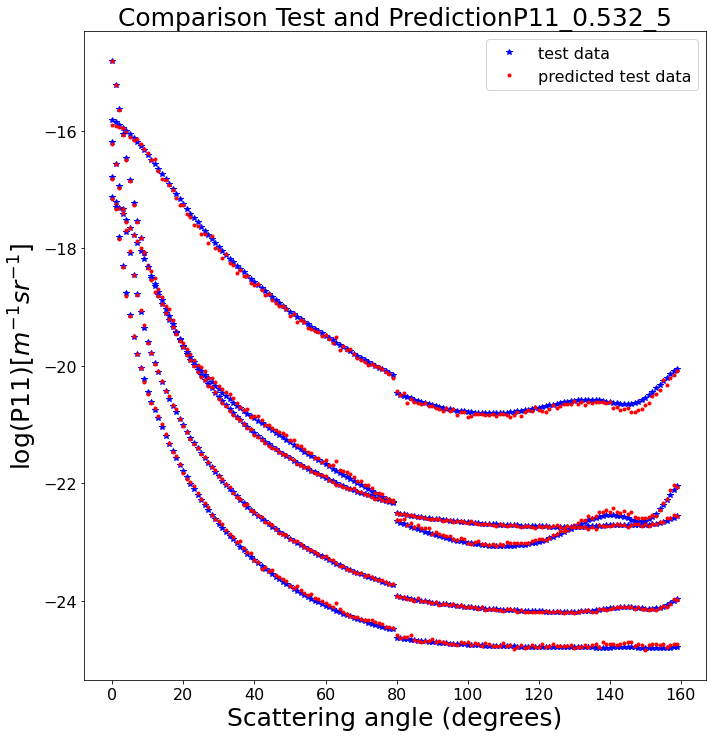

In [88]:
for wl_item in wl_list_P11:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('log(P11)[$m^{-1}sr^{-1}$]',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

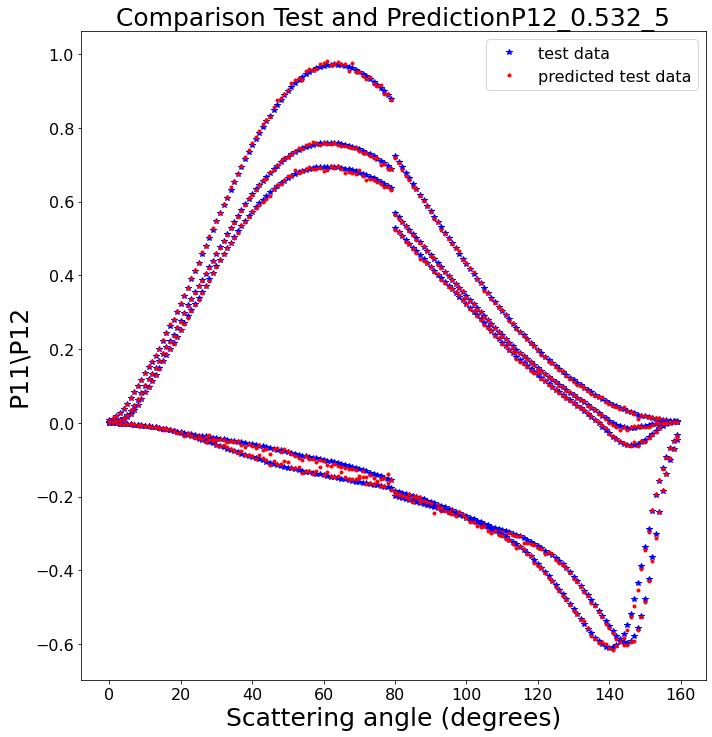

In [89]:
for wl_item in wl_list_P12:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')
    
    

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('P11\P12',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    mu1 = dvar_pred_iv.iloc[datapoint]['R_median']
    sigma1 = dvar_pred_iv.iloc[datapoint]['GSD']
    mu2 = dvar_test.iloc[datapoint]['R_median']
    sigma2 = dvar_test.iloc[datapoint]['GSD']
    Vtot1 = dvar_pred_iv.iloc[datapoint]['V_tot']
    Vtot2 = dvar_test.iloc[datapoint]['V_tot']
    
    
    s1 = np.random.lognormal(mu1, sigma1, 10000)
    s2 = np.random.lognormal(mu2, sigma2, 10000)


    count1, bins1, ignored1 = plt.hist(s1, 10000, density=True, align='mid')
    count2, bins2, ignored2 = plt.hist(s2, 10000, density=True, align='mid')

    x1 = np.linspace(min(bins1), max(bins1), 100000)
    x2 = np.linspace(min(bins2), max(bins2), 100000)

    pdf1 = Vtot1*(np.exp(-(np.log(x1) - mu1)**2 / (2 * sigma1**2)) / (x1 * sigma1 * np.sqrt(2 * np.pi)))
    pdf2 = Vtot2*(np.exp(-(np.log(x2) - mu2)**2 / (2 * sigma2**2)) / (x2 * sigma2 * np.sqrt(2 * np.pi)))

    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1, label = 'Simulated test data')
    else:
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

# plot correlation test data and predicted test data

In [ ]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred_fw.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

In [ ]:
for key in dvar_columns:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(dvar_test[key],dvar_pred_iv[key],".")
    ax.plot(dvar_test[key],dvar_test[key],"r")
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

In [ ]:
for key in dvar_test.columns:
    dvar_test_help = dvar_test.sort_values(key)
    dvar_pred_iv_df_help = dvar_pred_iv.loc[dvar_test_help.index]

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.plot(np.arange(0,len(dvar_test_help)),dvar_test_help[key],'b.', markersize = '1')
    ax.plot(np.arange(0,len(dvar_pred_iv_df_help)),dvar_pred_iv_df_help[key],'r.', markersize = '1')
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

# plot r2 for forward and inverse model

In [ ]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
ax.set_ylabel('r2_adj')

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.savefig(f'{plot_dir}/invertible_model_fw_r2_adj.jpg')


In [ ]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_model_inv_r2_adj.jpg')



# Plot Relative Errors / Absolute errors

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_fw_P11,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_fw_P11.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('relative error P11', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))

fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_fw_P12,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(abs_error_table_fw_P12.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('absolute error P11/P12', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
      #      annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_sampling_rel_error_percentiles.jpg')


In [ ]:
# Rework plots below

In [ ]:
surr.model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(surr.model, show_shapes=False,show_layer_names=True,to_file = f'{plot_dir}/model_architecture_invertible.png')


In [ ]:
r2_adj_fw = r2_adj_fw.rename({0: 'r2_adj'}, axis='index')
r2_adj_iv = r2_adj_iv.rename({0: 'r2_adj'}, axis='index')


# create overview plot

In [ ]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_fw.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_fw,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_fw.jpg')
'''


In [ ]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_iv,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_iv.jpg')
'''


In [ ]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

In [ ]:
store_results = pd.DataFrame()


In [ ]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/learning_rate']
store_results['n_blocks'] = configs['config/n_blocks']
store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']
store_results['weight_x'] = configs['config/weight_x']
store_results['weight_y'] = configs['config/weight_y']
store_results['weight_z'] = configs['config/weight_z']
store_results['weight_artificial'] = configs['config/weight_artificial']
store_results['weight_reconstruction'] = configs['config/weight_reconstruction']
store_results['r2_val_qoi_mean'] = configs['r2_val']
store_results['r2_test_qoi_mean'] = r2_adj_fw.mean(axis =1).values
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_fw_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_fw_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_fw_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_fw_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['rel_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)

store_results['r2_val_dvar_mean'] = configs['r2_val_dvar']
store_results['r2_test_dvar_mean'] = r2_adj_iv.mean(axis = 1).values



store_results['r2_test_dvar_V'] = r2_adj_iv['V_tot']['r2_adj']
store_results['rel_error95%_dvar_V'] = rel_error_table_iv['V_tot']['95%']
store_results['abs_error95%_dvar_V'] = abs_error_table_iv['V_tot']['95%']
store_results['MAE_dvar_V'] = MAE_all_dvar['V_tot'].values
store_results['MAPE%_dvar_V'] = MAPE_all_dvar['V_tot'].values
store_results['explained_variance_dvar_V'] = EVS_dvar['V_tot']

store_results['r2_test_dvar_R'] = r2_adj_iv['R_median']['r2_adj']
store_results['rel_error95%_dvar_R'] = rel_error_table_iv['R_median']['95%']
store_results['abs_error95%_dvar_R'] = abs_error_table_iv['R_median']['95%']
store_results['MAE_dvar_R'] = MAE_all_dvar['R_median'].values
store_results['MAPE%_dvar_R'] = MAPE_all_dvar['R_median'].values
store_results['explained_variance_dvar_R'] = EVS_dvar['R_median']

store_results['r2_test_dvar_GSD'] = r2_adj_iv['GSD']['r2_adj']
store_results['rel_error95%_dvar_GSD'] = rel_error_table_iv['GSD']['95%']
store_results['abs_error95%_dvar_GSD'] = abs_error_table_iv['GSD']['95%']
store_results['MAE_dvar_GSD'] = MAE_all_dvar['GSD'].values
store_results['MAPE%_dvar_GSD'] = MAPE_all_dvar['GSD'].values
store_results['explained_variance_dvar_GSD'] = EVS_dvar['GSD']

if 'n' in dvar_columns:  
    store_results['r2_test_dvar_n'] = r2_adj_iv['n']['r2_adj']
    store_results['rel_error95%_dvar_n'] = rel_error_table_iv['n']['95%']
    store_results['abs_error95%_dvar_n'] = abs_error_table_iv['n']['95%']
    store_results['MAE_dvar_n'] = MAE_all_dvar['n'].values
    store_results['MAPE%_dvar_n'] = MAPE_all_dvar['n'].values
    store_results['explained_variance_dvar_n'] = EVS_dvar['n']
else:
    store_results['r2_test_dvar_n'] = 0
    store_results['rel_error95%_dvar_n'] = 0
    store_results['abs_error95%_dvar_n'] = 0
    store_results['MAE_dvar_n'] = 0
    store_results['MAPE%_dvar_n'] = 0
    store_results['explained_variance_dvar_n'] = 0   



if 'n_532nm' in dvar_columns:    
    store_results['r2_test_dvar_n_532'] = r2_adj_iv['n_532nm']['r2_adj']
    store_results['rel_error95%_dvar_n_532'] = rel_error_table_iv['n_532nm']['95%']
    store_results['abs_error95%_dvar_n_532'] = abs_error_table_iv['n_532nm']['95%']
    store_results['MAE_dvar_n_532'] = MAE_all_dvar['n_532nm'].values
    store_results['MAPE%_dvar_n_532'] = MAPE_all_dvar['n_532nm'].values
    store_results['explained_variance_dvar_n_532'] = EVS_dvar['n_532nm']

else:
    store_results['r2_test_dvar_n_532'] = 0
    store_results['rel_error95%_dvar_n_532'] = 0
    store_results['abs_error95%_dvar_n_532'] = 0
    store_results['MAE_dvar_n_532'] = 0
    store_results['MAPE%_dvar_n_532'] = 0
    store_results['explained_variance_dvar_n_532'] = 0


if 'k_532nm' in dvar_columns:    
    store_results['r2_test_dvar_k_532'] = r2_adj_iv['k_532nm']['r2_adj']
    store_results['rel_error95%_dvar_k_532'] = rel_error_table_iv['k_532nm']['95%']
    store_results['abs_error95%_dvar_k_532'] = abs_error_table_iv['k_532nm']['95%']
    store_results['MAE_dvar_k_532'] = MAE_all_dvar['k_532nm'].values
    store_results['MAPE%_dvar_k_532'] = MAPE_all_dvar['k_532nm'].values
    store_results['explained_variance_dvar_k_532'] = EVS_dvar['k_532nm']

else:
    store_results['r2_test_dvar_k_532'] = 0
    store_results['rel_error95%_dvar_k_532'] = 0
    store_results['abs_error95%_dvar_k_532'] = 0
    store_results['MAE_dvar_k_532'] = 0
    store_results['MAPE%_dvar_k_532'] = 0
    store_results['explained_variance_dvar_k_532'] = 0
    
if 'n_450nm' in dvar_columns:  
    store_results['r2_test_dvar_n_450'] = r2_adj_iv['n_450nm']['r2_adj']
    store_results['rel_error95%_dvar_n_450'] = rel_error_table_iv['n_450nm']['95%']
    store_results['abs_error95%_dvar_n_450'] = abs_error_table_iv['n_450nm']['95%']
    store_results['MAE_dvar_n_450'] = MAE_all_dvar['n_450nm'].values
    store_results['MAPE%_dvar_n_450'] = MAPE_all_dvar['n_450nm'].values
    store_results['explained_variance_dvar_n_450'] = EVS_dvar['n_450nm']
    
else:
    store_results['r2_test_dvar_n_450'] = 0
    store_results['rel_error95%_dvar_n_450'] = 0
    store_results['abs_error95%_dvar_n_450'] = 0
    store_results['MAE_dvar_n_450'] = 0
    store_results['MAPE%_dvar_n_450'] = 0
    store_results['explained_variance_dvar_n_450'] = 0
    
if 'k_450nm' in dvar_columns:  
    store_results['r2_test_dvar_k_450'] = r2_adj_iv['k_450nm']['r2_adj']
    store_results['rel_error95%_dvar_k_450'] = rel_error_table_iv['k_450nm']['95%']
    store_results['abs_error95%_dvar_k_450'] = abs_error_table_iv['k_450nm']['95%']
    store_results['MAE_dvar_k_450'] = MAE_all_dvar['k_450nm'].values
    store_results['MAPE%_dvar_k_450'] = MAPE_all_dvar['k_450nm'].values
    store_results['explained_variance_dvar_k_450'] = EVS_dvar['k_450nm']
    
else:
    store_results['r2_test_dvar_k_450'] = 0
    store_results['rel_error95%_dvar_k_450'] = 0
    store_results['abs_error95%_dvar_k_450'] = 0
    store_results['MAE_dvar_k_450'] = 0
    store_results['MAPE%_dvar_k_450'] = 0
    store_results['explained_variance_dvar_k_450'] = 0
    
if 'n_630nm' in dvar_columns:    
    store_results['r2_test_dvar_n_630'] = r2_adj_iv['n_630nm']['r2_adj']
    store_results['rel_error95%_dvar_n_630'] = rel_error_table_iv['n_630nm']['95%']
    store_results['abs_error95%_dvar_n_630'] = abs_error_table_iv['n_630nm']['95%']
    store_results['MAE_dvar_n_630'] = MAE_all_dvar['n_630nm'].values
    store_results['MAPE%_dvar_n_630'] = MAPE_all_dvar['n_630nm'].values
    store_results['explained_variance_dvar_n_630'] = EVS_dvar['n_630nm']
else:
    store_results['r2_test_dvar_n_630'] = 0
    store_results['rel_error95%_dvar_n_630'] = 0
    store_results['abs_error95%_dvar_n_630'] = 0
    store_results['MAE_dvar_n_630'] =0
    store_results['MAPE%_dvar_n_630'] =0
    store_results['explained_variance_dvar_n_630'] = 0
      
    
if 'k_630nm' in dvar_columns:    
    store_results['r2_test_dvar_k_630'] = r2_adj_iv['k_630nm']['r2_adj']
    store_results['rel_error95%_dvar_k_630'] = rel_error_table_iv['k_630nm']['95%']
    store_results['abs_error95%_dvar_k_630'] = abs_error_table_iv['k_630nm']['95%']
    store_results['MAE_dvar_k_630'] = MAE_all_dvar['k_630nm'].values
    store_results['MAPE%_dvar_k_630'] = MAPE_all_dvar['k_630nm'].values
    store_results['explained_variance_dvar_k_630'] = EVS_dvar['k_630nm']
else:
    store_results['r2_test_dvar_k_630'] = 0
    store_results['rel_error95%_dvar_k_630'] = 0
    store_results['abs_error95%_dvar_k_630'] = 0
    store_results['MAE_dvar_k_630'] =0
    store_results['MAPE%_dvar_k_630'] =0
    store_results['explained_variance_dvar_k_630'] = 0
    







store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

In [ ]:
store_results.to_csv(f'{model_dir}/results_summary1.csv')


In [ ]:
store_results

In [ ]:
model_dir